In [30]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 180)


PROJECT_ROOT = Path.cwd()
BASE_DIR = (PROJECT_ROOT / "Data").resolve()


In [31]:

def safe_read_parquet(path: str, columns: list | None = None) -> pd.DataFrame:
    
    try:
        return pd.read_parquet(path, engine="pyarrow", columns=columns)
    except Exception as e:
        msg = str(e)
        # 2) Spezifischer Workaround: Extension deregistrieren und Retry
        if "pandas.period already defined" in msg:
            try:
                import pyarrow as pa
                try:
                    pa.unregister_extension_type("pandas.period")
                except Exception:
                    pass
                return pd.read_parquet(path, engine="pyarrow", columns=columns)
            except Exception as e2:
                msg = f"{msg} | Retry failed: {e2}"
        # 3) Fallback fastparquet (optional)
        try:
            return pd.read_parquet(path, engine="fastparquet", columns=columns)
        except Exception as e3:
            raise RuntimeError(
                f"Failed to read {path}\n"
                f"pyarrow error: {msg}\n"
                f"fastparquet error: {e3}"
            )


In [32]:


ALL_PARQUETS = sorted(glob.glob(os.path.join(BASE_DIR, "**", "*.parquet"), recursive=True))
print("Gefundene Dateien:", len(ALL_PARQUETS))
ALL_PARQUETS[:8]


Gefundene Dateien: 8


['C:\\Users\\Mert\\Desktop\\DataEngProj\\DataEngineering\\Data\\fhv_tripdata_2023-01.parquet',
 'C:\\Users\\Mert\\Desktop\\DataEngProj\\DataEngineering\\Data\\fhv_tripdata_2023-02.parquet',
 'C:\\Users\\Mert\\Desktop\\DataEngProj\\DataEngineering\\Data\\green_tripdata_2025-05.parquet',
 'C:\\Users\\Mert\\Desktop\\DataEngProj\\DataEngineering\\Data\\green_tripdata_2025-06.parquet',
 'C:\\Users\\Mert\\Desktop\\DataEngProj\\DataEngineering\\Data\\green_tripdata_2025-07.parquet',
 'C:\\Users\\Mert\\Desktop\\DataEngProj\\DataEngineering\\Data\\yellow_tripdata_2023-01.parquet',
 'C:\\Users\\Mert\\Desktop\\DataEngProj\\DataEngineering\\Data\\yellow_tripdata_2023-02.parquet',
 'C:\\Users\\Mert\\Desktop\\DataEngProj\\DataEngineering\\Data\\yellow_tripdata_2024-01.parquet']

In [33]:
def _pick_first(colset: set, candidates: list):
    for c in candidates:
        if c in colset:
            return c
    return None

def _vendor_from_name(path: str) -> str:
    b = os.path.basename(path).lower()
    if b.startswith("yellow"): return "yellow"
    if b.startswith("green"):  return "green"
    if b.startswith("fhvhv"):  return "fhvhv"
    if b.startswith("fhv"):    return "fhv"
    return "unknown"

PICKUP_CANDS  = ["tpep_pickup_datetime","lpep_pickup_datetime","pickup_datetime","pickup_datetime_ltz","Pickup_datetime","PUdatetime"]
DROPOFF_CANDS = ["tpep_dropoff_datetime","lpep_dropoff_datetime","dropoff_datetime","dropOff_datetime","Dropoff_datetime","DOdatetime"]
PU_CANDS      = ["PULocationID","PUlocationID","pu_location_id","puLocationID"]
DO_CANDS      = ["DOLocationID","DOlocationID","do_location_id","doLocationID"]
DIST_CANDS    = ["trip_distance","Trip_distance"]
FARE_CANDS    = ["fare_amount","base_passenger_fare","Fare_amount"]
TIP_CANDS     = ["tip_amount","tips","Tip_amount"]

def normalize_schema(df: pd.DataFrame, vendor: str, src: str) -> pd.DataFrame:
    cols = set(df.columns)

    pc  = _pick_first(cols, PICKUP_CANDS)
    dc  = _pick_first(cols, DROPOFF_CANDS)
    puc = _pick_first(cols, PU_CANDS)
    doc = _pick_first(cols, DO_CANDS)
    dic = _pick_first(cols, DIST_CANDS)
    fac = _pick_first(cols, FARE_CANDS)
    tic = _pick_first(cols, TIP_CANDS)

    # Optional: Diagnose – sieht man in der Ausgabe welche Spalten gemappt wurden
    print(f"→ {os.path.basename(src)} | pickup:{pc} dropoff:{dc} PU:{puc} DO:{doc} dist:{dic} fare:{fac} tip:{tic}")

    out = pd.DataFrame({
        "pickup_datetime":  pd.to_datetime(df[pc], errors="coerce") if pc  else pd.NaT,
        "dropoff_datetime": pd.to_datetime(df[dc], errors="coerce") if dc else pd.NaT,
        "PULocationID":     pd.to_numeric(df[puc], errors="coerce") if puc else np.nan,
        "DOLocationID":     pd.to_numeric(df[doc], errors="coerce") if doc else np.nan,
        "trip_distance":    pd.to_numeric(df[dic], errors="coerce") if dic else np.nan,
        "fare_amount":      pd.to_numeric(df[fac], errors="coerce") if fac else np.nan,
        "tip_amount":       pd.to_numeric(df[tic], errors="coerce") if tic else np.nan,
    })
    out["vendor"] = vendor
    out["source_path"] = src
    return out


In [34]:

frames, bad = [], []

for i, p in enumerate(ALL_PARQUETS, 1):
    try:
        raw = safe_read_parquet(p)
        df_norm = normalize_schema(raw, _vendor_from_name(p), p)
        frames.append(df_norm)
    except Exception as e:
        bad.append((p, str(e)))
    if i % 10 == 0:
        print(f"{i}/{len(ALL_PARQUETS)} verarbeitet …")

if not frames:
    raise RuntimeError("Keine Datei geladen – prüfe pyarrow-Installation & Pfade.")

trips = pd.concat(frames, ignore_index=True)
print("trips (roh):", trips.shape)
print("Problemdateien:", len(bad))


→ fhv_tripdata_2023-01.parquet | pickup:pickup_datetime dropoff:dropOff_datetime PU:PUlocationID DO:DOlocationID dist:None fare:None tip:None
→ fhv_tripdata_2023-02.parquet | pickup:pickup_datetime dropoff:dropOff_datetime PU:PUlocationID DO:DOlocationID dist:None fare:None tip:None
→ green_tripdata_2025-05.parquet | pickup:lpep_pickup_datetime dropoff:lpep_dropoff_datetime PU:PULocationID DO:DOLocationID dist:trip_distance fare:fare_amount tip:tip_amount
→ green_tripdata_2025-06.parquet | pickup:lpep_pickup_datetime dropoff:lpep_dropoff_datetime PU:PULocationID DO:DOLocationID dist:trip_distance fare:fare_amount tip:tip_amount
→ green_tripdata_2025-07.parquet | pickup:lpep_pickup_datetime dropoff:lpep_dropoff_datetime PU:PULocationID DO:DOLocationID dist:trip_distance fare:fare_amount tip:tip_amount
→ yellow_tripdata_2023-01.parquet | pickup:tpep_pickup_datetime dropoff:tpep_dropoff_datetime PU:PULocationID DO:DOLocationID dist:trip_distance fare:fare_amount tip:tip_amount
→ yellow_tr

In [35]:

# Dauer in Minuten
trips["duration_min"] = (trips["dropoff_datetime"] - trips["pickup_datetime"]).dt.total_seconds() / 60.0

# Zeilen mit fehlenden Datetimes/PU raus
trips = trips.dropna(subset=["pickup_datetime","dropoff_datetime","PULocationID"])

trips = trips[(trips["duration_min"] > 0) & (trips["duration_min"] <= 180)]
if "trip_distance" in trips.columns:
    trips = trips[(trips["trip_distance"].isna()) |
                  ((trips["trip_distance"] >= 0) & (trips["trip_distance"] <= 100))]

trips["hour"] = trips["pickup_datetime"].dt.hour.astype("int16")

print("trips (gefiltert):", trips.shape)
trips.head(5)


trips (gefiltert): (9554411, 11)


,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,tip_amount,vendor,source_path,duration_min,hour
20,2023-01-01 00:00:20,2023-01-01 00:38:41,132.0,265.0,NaN,NaN,NaN,fhv,C:\Users\Mert\Desktop\DataEngProj\DataEngineer...,38.350000,0
21,2023-01-01 00:30:10,2023-01-01 00:48:51,65.0,158.0,NaN,NaN,NaN,fhv,C:\Users\Mert\Desktop\DataEngProj\DataEngineer...,18.683333,0
61,2023-01-01 00:45:35,2023-01-01 01:04:26,95.0,15.0,NaN,NaN,NaN,fhv,C:\Users\Mert\Desktop\DataEngProj\DataEngineer...,18.850000,0
62,2023-01-01 00:09:48,2023-01-01 00:29:53,236.0,234.0,NaN,NaN,NaN,fhv,C:\Users\Mert\Desktop\DataEngProj\DataEngineer...,20.083333,0
73,2023-01-01 00:45:31,2023-01-01 00:50:32,206.0,245.0,NaN,NaN,NaN,fhv,C:\Users\Mert\Desktop\DataEngProj\DataEngineer...,5.016667,0


In [36]:


avg_duration_by_pu = (trips.groupby("PULocationID", dropna=False)["duration_min"]
                      .mean()
                      .reset_index(name="avg_duration_min")
                      .sort_values("avg_duration_min", ascending=False))

avg_duration_by_pu.head(10)


,PULocationID,avg_duration_min
85,86.0,51.093277
113,117.0,46.577224
129,133.0,42.088986
26,27.0,39.574269
197,201.0,39.109895
135,139.0,37.583750
201,205.0,36.253978
128,132.0,36.185363
199,203.0,36.114972
45,46.0,35.478723


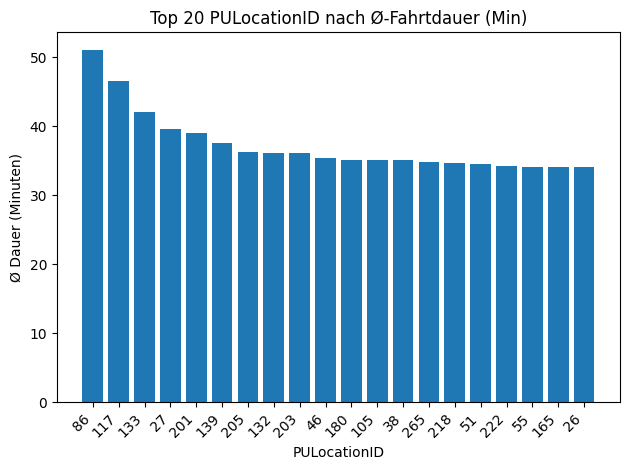

In [37]:
# Plot: Top 20 Zonen nach Ø-Dauer
topN = 20
top_dur = avg_duration_by_pu.head(topN)

plt.figure()
plt.bar(top_dur["PULocationID"].astype(int).astype(str), top_dur["avg_duration_min"])
plt.title(f"Top {topN} PULocationID nach Ø-Fahrtdauer (Min)")
plt.xlabel("PULocationID")
plt.ylabel("Ø Dauer (Minuten)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


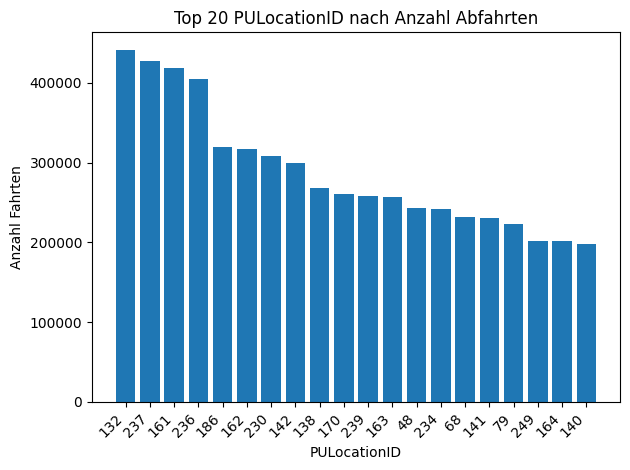

In [38]:
pu_counts = (trips.groupby("PULocationID", dropna=False)
             .size()
             .reset_index(name="trips")
             .sort_values("trips", ascending=False))
pu_counts.head(10)
topN = 20
top_counts = pu_counts.head(topN)

plt.figure()
plt.bar(top_counts["PULocationID"].astype(int).astype(str), top_counts["trips"])
plt.title(f"Top {topN} PULocationID nach Anzahl Abfahrten")
plt.xlabel("PULocationID")
plt.ylabel("Anzahl Fahrten")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

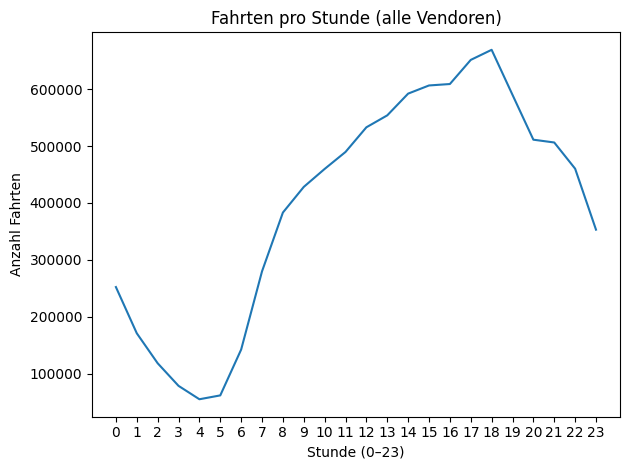

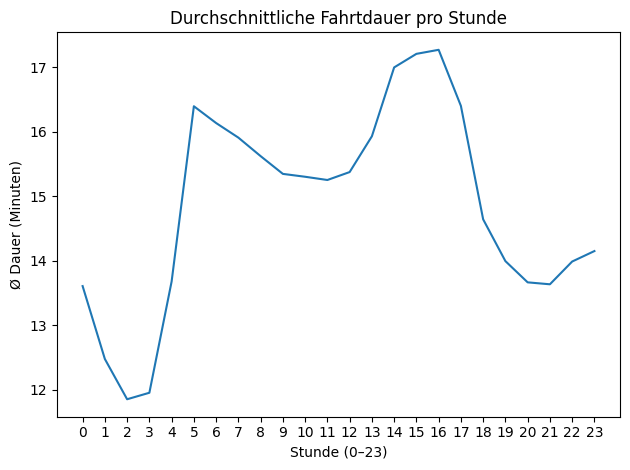

In [39]:
by_hour = (trips.groupby("hour")
           .agg(trips=("vendor","count"),
                avg_duration=("duration_min","mean"))
           .reset_index()
           .sort_values("hour"))

plt.figure()
plt.plot(by_hour["hour"], by_hour["trips"])
plt.title("Fahrten pro Stunde (alle Vendoren)")
plt.xlabel("Stunde (0–23)")
plt.ylabel("Anzahl Fahrten")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(by_hour["hour"], by_hour["avg_duration"])
plt.title("Durchschnittliche Fahrtdauer pro Stunde")
plt.xlabel("Stunde (0–23)")
plt.ylabel("Ø Dauer (Minuten)")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()


In [40]:
def time_bucket(h: int) -> str:
    if (21 <= h <= 23) or (0 <= h <= 5):
        return "Night (21–4)"               
    if 6 <= h <= 9:
        return "Morning Rush (5–9)"
    if 10 <= h <= 14:
        return "Mid-day (10–14)"
    if 15 <= h <= 19:
        return "Evening Rush (15–19)"
    return "Late Evening (20-21)"

trips["time_bucket"] = trips["hour"].apply(time_bucket)

bucket_stats = (trips.groupby("time_bucket")
                .agg(trips=("vendor","count"),
                     avg_duration=("duration_min","mean"))
                .reset_index()
                .sort_values("trips", ascending=False))

bucket_stats


,time_bucket,trips,avg_duration
0,Evening Rush (15–19),3126461,15.895055
2,Mid-day (10–14),2628609,15.820759
4,Night (21–4),2055077,13.619127
3,Morning Rush (5–9),1233068,15.649460
1,Late Evening (20-21),511196,13.664044


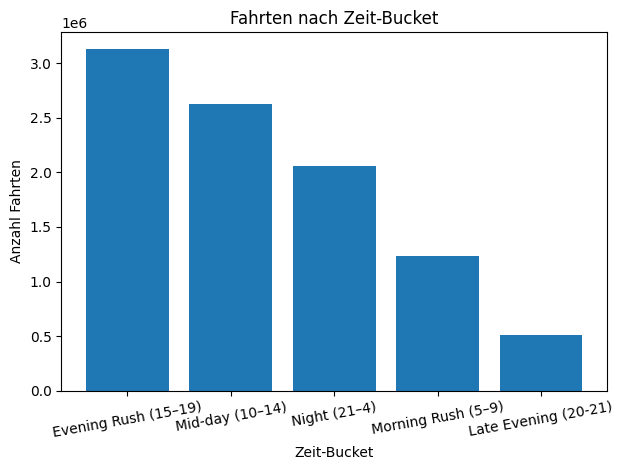

In [41]:
plt.figure()
plt.bar(bucket_stats["time_bucket"], bucket_stats["trips"])
plt.title("Fahrten nach Zeit-Bucket")
plt.xlabel("Zeit-Bucket")
plt.ylabel("Anzahl Fahrten")
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()
